In [73]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None

In [112]:
#Fall-Spring 22-23 data
course_grades = pd.read_csv("Student Course Grades.csv", low_memory=False)
stu_gpas = pd.read_csv("historic_bus_gpa.csv", low_memory=False)

stu_gpas= stu_gpas[stu_gpas["Term"].str.contains("Summer")==False] #REMOVE SUMMER TERMS

def func(row): # could do this as apply lambda too
    if row["Academic Lev"] < 11 :
        return "Freshman"
    elif row["Academic Lev"] > 10 and row["Academic Lev"]<21:
        return "Sophomore"
    elif row["Academic Lev"] > 20 and row["Academic Lev"]<31:
        return "Junior"
    else:
        return 'Senior'

stu_gpas["Academic Level"] = stu_gpas.apply(func, axis=1) #CHANGE TO STRING LEVEL

In [113]:
course_grades = course_grades[["Term", "Academic Level", "Campus ID", "Catalog Number", "Course Title", "Official Grade"]]

stu_gpas = stu_gpas[["Term", "Campus ID", "Academic Level", "Cumulative GPA", "Term GPA"]]
stu_gpas= stu_gpas.drop_duplicates()

for_pred = course_grades.merge(stu_gpas, how="left", on=[ "Campus ID", "Academic Level"]) #should ideally start w dependent obs and add on indepent

#FILL CUMU IF MISSING WITH TERM GPA
for_pred["Cumulative GPA"] = np.where(for_pred["Cumulative GPA"] == "NaN", for_pred["Term GPA"], for_pred["Cumulative GPA"])

#Checking
#for_pred[for_pred["Campus ID"]==9082071771] #!!!!!!!!!
#for_pred[for_pred["Campus ID"]==9082080731]
#for_pred[for_pred["Campus ID"]==9083318569]
#for_pred[ for_pred["Campus ID"]==9082999005]

In [114]:
#for_pred

In [115]:
for_pred["Class"] = for_pred["Course Title"] + " " + for_pred["Catalog Number"].astype(str) 
for_pred= for_pred[for_pred["Official Grade"].str.contains("W|SD|S", regex=True)==False] 
for_pred = for_pred.pivot_table(values= "Official Grade", index=["Campus ID", "Academic Level", "Cumulative GPA"], columns=["Class"], aggfunc="first")

for_pred = for_pred.replace("A", 4.0)
for_pred = for_pred.replace("AB", 3.5)
for_pred = for_pred.replace("B", 3.0)
for_pred = for_pred.replace("BC", 2.5)
for_pred = for_pred.replace("C", 2.0)
for_pred = for_pred.replace("D", 1.0)
for_pred = for_pred.replace("F", 0.0)
for_pred = for_pred.replace("I", 0.0)
for_pred = for_pred.replace("UD", 0.0)
for_pred = for_pred.replace("NW", 0.0)
for_pred = for_pred.replace("No grade (Null)", 0.0)

for_pred = for_pred.reset_index()

#SHOW MOST RECENT/SPRING CUMU GPA
for_pred = for_pred.groupby(["Campus ID", "Academic Level"]).agg(func="first") ##sort here !!!!!!!!
for_pred = for_pred.reset_index()
for_pred["Campus ID"] = for_pred["Campus ID"].astype(str)

In [116]:
pd.set_option('display.max_rows', None)
for_pred["Elem Matrix&Linear Algebra 340"].value_counts()

Elem Matrix&Linear Algebra 340
4.0    22
3.5     8
3.0     6
2.0     6
2.5     5
0.0     2
1.0     1
Name: count, dtype: int64

In [117]:
#IF ECON 101 & 102 EMPTY THEN MOVE ACCEL 111 CLASS GRADE OVER
for_pred["Principles-Macroeconomics 102"] = np.where(( for_pred[["Principles-Macroeconomics 102", "Principles-Microeconomics 101"]].isnull().sum(axis=1) ==2) \
                                                     & (for_pred["Prin/Econ-Accelratd Treatmt 111"].isnull()==False), \
                                                     for_pred["Prin/Econ-Accelratd Treatmt 111"], for_pred["Principles-Macroeconomics 102"])

for_pred["Principles-Microeconomics 101"] = np.where(( for_pred[["Principles-Microeconomics 101"]].isnull().sum(axis=1) ==1) \
                                                     & (for_pred["Prin/Econ-Accelratd Treatmt 111"].isnull()==False), \
                                                     for_pred["Prin/Econ-Accelratd Treatmt 111"], for_pred["Principles-Microeconomics 101"])


#SORT BY FRESH, SOPH, JUNIOR, SENIOR
for_pred["Academic Level"] = pd.Categorical(for_pred["Academic Level"], categories=['Freshman', 'Sophomore', 'Junior', 'Senior'])
for_pred=for_pred.sort_values("Academic Level")

In [118]:
#GROUPING AND FILTERING DOWN CLASSES
merging=[]
for col in for_pred.columns:
    if "Calculus" in col:
        merging.append(col)
        continue
    if "Calc" in col:
        merging.append(col)
        
        
pre_calc = ["Algebra 112", "Algebra and Trigonometry 114", "College Geometry I 461", "Preparatory Algebra 96", "Trigonometry 113",  "Quant Reasoning&Prob Solvng 141"]

post_calc = ["Elementary Topology 551", "Elem Matrix & Linear Algebra 340", 'Elem Matrix&Linear Algebra 340', "Intro to Discrete Mathematics 240", "Intro to Prob & Math Stat I 309", 
             "Intro-Combinatorics 475", "Intro to Prob & Math Stat II 310","Intro-Combinatorics 475", "Intro-Stochastic Processes 632", "Intro-Theory of Probability 431", \
             "Linear Alg & Diff Equations 320", "Linear Algebra 341", "Linear Algebra II 540", "Modern Algebra 541", "Numerical Linear Algebra 513", "Tech-Ordinary Diff Equation 319", \
             "Appl Dyn Sys, Chaos&Modelng 415",  'Probability Theory 531', 'Introduction to Number Theory 467', 'Intro to Fourier Analysis 627']

analytics = ["Data Visualization for Econ 315", "Econ Data Analysis 695", "Fund Data Analytics for Econ 570", "Intro Applied Econometrics 400", "Quant Tools for Economics 205", \
             "Introductory Econometrics 410", "Stats:Measrmnt in Economics 310", "Analysis I 521", "Analytical Public Finance 441", "Linear Optimization 525", 'Math Methods in Data Science 535']

to_drop = ["Latin Amer Economc Develpmt 462", "The Real Estate Process 306", "Agri & Econ Development-Africa 477", "Study Abroad-Intermed Econ 309", 'Study Abroad-Adv Economics 409', \
           'Directed Study 699', 'Econ Approach Current Issues 100', 'Honors Thesis 581', "Econ Grwth&Devlpmnt-SE Asia 473", "Honors-Research Proj Design 580", "Prin/Econ-Accelratd Treatmt 111"]

adv_econ = ["Behavioral Economics 455", "Econ Probs-Developing Areas 474",  "Economics of Growth 475", "Economics of Health Care 548", "Game Theory & Economic Anal 521", \
            "Indus Organizat/Imperf Comp 468", "Indust Struct&Comptitv Stratgy 458", "International Macroeconomics 461", "International Trade 464", "Intl Industrial Organizations 467", \
            "Intmed Macroecon-Adv Treatment 312", "Intmed Macroeconomic Theory 302", "Intmed Microeconomic Theory 301", "Intmed Microecon-Adv Treatment 311", "Investment Theory 320", \
            "Law and Economics 522", "Money and Banking 330", "Topics in Economics 690", "Urban & Regional Economics 420", "Wages and the Labor Market 450", 'Contemporary Economic Issues 390', \
            'Economic Forecasting 460', 'Energy, Resources & Economics 371', 'Environmental Economics 343', 'Issues in Internatl Macro 661', 'Issues-International Finance 666', \
            'Macroeconomic Policy 442', 'Markets and Models 621', 'Markets with Frictions 503', "Insuring Life's Risks 530", 'Econ of Growing Up/Getting Old 355', 'Economics Poverty Inequality 370', \
            'Introduction to Cryptography 435', 'Survey-Internatl Economics 364']

            
#FOR EACH GROUP DOING A CUMU COUNT OF CLASSES TAKEN & CUMU GRADE AVG
sections = ["Calc", "Pre Calc", "Post Calc", "Analytics", "Adv Econ"]
sect_lists = [merging, pre_calc, post_calc, analytics, adv_econ]

for i in range(len(sections)):
    for_pred[sections[i]] = for_pred[sect_lists[i]].mean(axis=1)
    for_pred["{} Count".format(sections[i])] = len(sect_lists[i]) - for_pred[sect_lists[i]].isnull().sum(axis=1)
    for_pred["{} Count".format(sections[i])] = for_pred.groupby(['Campus ID'])["{} Count".format(sections[i])].cumsum()
    for_pred["shift {}".format(sections[i])] = for_pred.groupby(['Campus ID'])[sections[i]].shift(1)
    for_pred["shift {} Count".format(sections[i])] = for_pred.groupby(['Campus ID'])["{} Count".format(sections[i])].shift(1) 
    for_pred[sections[i]] = np.where((for_pred["shift {} Count".format(sections[i])].isnull()==False) & (for_pred[sections[i]].isnull()==False) & (for_pred["{} Count".format(sections[i])]>1), \
                                round( ((for_pred["shift {}".format(sections[i])]*for_pred["shift {} Count".format(sections[i])]) + for_pred[sect_lists[i]].mean(axis=1)) / for_pred["{} Count".format(sections[i])], 2), \
                                for_pred[sections[i]])

    for_pred.drop(sect_lists[i], axis=1, inplace=True)
    for_pred.drop("shift {}".format(sections[i]), axis=1, inplace=True)
    for_pred.drop("shift {} Count".format(sections[i]), axis=1, inplace=True)
    for_pred[sections[i]] = for_pred.groupby(['Campus ID'])[sections[i]].fillna(method="ffill")

    
#IF THEY DO ONE OF THESE CLASSES IN EARLY YEARS THEIR GRADE CARRIES OVER
for_pred['Principles-Microeconomics 101'] = for_pred.groupby(['Campus ID'])['Principles-Microeconomics 101'].fillna(method="ffill")
for_pred["Principles-Macroeconomics 102"] = for_pred.groupby(['Campus ID'])["Principles-Macroeconomics 102"].fillna(method="ffill")
for_pred["Introduction to Finance 300"] = for_pred.groupby(['Campus ID'])["Introduction to Finance 300"].fillna(method="ffill")


for_pred.drop(to_drop, axis=1, inplace=True)


#Checking
#for_pred.loc[ (for_pred["Campus ID"]=="9082080731") | (for_pred["Campus ID"]=="9083318569") ]
#for_pred[ for_pred["Campus ID"] =="9082999005"]

In [119]:
#ACADEMIC LEVEL TO NUMBERS
for_pred["Academic Level"] = for_pred["Academic Level"].astype('category')
for_pred['Academic Codes'] = for_pred["Academic Level"].cat.codes

#removes students who now have no grades present bc they were from the classes we dropped
for_pred = for_pred[for_pred.isnull().sum(axis=1) <12]

In [120]:
for_pred.to_excel("class_gpa_filt.xlsx", "class_gpa_filt.xlsx")

# Regresion

In [121]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn.ensemble import HistGradientBoostingRegressor #they also have a classifier, can deal with NaN unlike GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

import statsmodels.api as sm 
from statsmodels.formula.api import ols

import seaborn as sns
import matplotlib.pyplot as plt

In [122]:
#SUBSET of full freshman cases of micro and calc & if they've taken a precalc class
sub1 = for_pred.loc[(for_pred["Academic Level"]=="Freshman") & (for_pred["Principles-Microeconomics 101"].isnull()==False) & (for_pred["Calc"].isnull()==False)]
sub1["Pre calc dummy"]= np.where(sub1["Pre Calc Count"]<1, 0 ,1)

#linear regression won't work on all cols because of NaN values
y = sub1["Cumulative GPA"]
X = sub1[["Academic Codes", "Principles-Microeconomics 101", "Calc", "Calc Count", "Pre calc dummy"]]
   
X_train, X_test, y_train, y_test = train_test_split(X, y)

regr = linear_model.LinearRegression() #linear fit with OLS minimizing by default
regr.fit(X_train, y_train)
regr.score(X_test, y_test) #same as r2 while

0.7339806269379112

In [123]:
#returns same values as above linear regression, this package is just nice to show a table
print( sm.OLS(y_train, sm.add_constant(X_train)).fit().summary() ) 

                            OLS Regression Results                            
Dep. Variable:         Cumulative GPA   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     318.0
Date:                Mon, 26 Feb 2024   Prob (F-statistic):          2.49e-128
Time:                        13:31:33   Log-Likelihood:                -126.08
No. Observations:                 445   AIC:                             262.2
Df Residuals:                     440   BIC:                             282.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Cumulative GPA   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     318.0
Date:                Mon, 26 Feb 2024   Prob (F-statistic):          2.49e-128
Time:                        13:31:33   Log-Likelihood:                -126.08
No. Observations:                 445   AIC:                             262.2
Df Residuals:                     440   BIC:                             282.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             1.1361      0.094     12.123      0.000       0.952       1.320
Academic Codes                -1.372e-15   1.31e-16    -10.477      0.000   -1.63e-15   -1.11e-15
Principles-Microeconomics 101     0.2966      0.026     11.599      0.000       0.246       0.347
Calc                              0.4362      0.019     22.880      0.000       0.399       0.474
Calc Count                       -0.1528      0.045     -3.427      0.001      -0.240      -0.065
Pre calc dummy                   -0.0573      0.045     -1.277      0.202      -0.145       0.031
==============================================================================
Omnibus:                      247.554   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3156.045
Skew:                          -2.106   Prob(JB):                         0.00
Kurtosis:                      15.348   Cond. No.                     1.21e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.69e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [87]:
# ALL GRADE LEVELS W MORE DUMMY VARS
sub2 = for_pred.loc[ (for_pred["Principles-Microeconomics 101"].isnull()==False) & (for_pred["Principles-Macroeconomics 102"].isnull()==False) & (for_pred["Calc"].isnull()==False)] 
sub2["Pre calc dummy"]= np.where(sub2["Pre Calc Count"]<1, 0 ,1)
sub2["Analytics dummy"]= np.where(sub2["Analytics Count"]<1, 0 ,1)
sub2["Adv Econ dummy"]= np.where(sub2["Adv Econ Count"]<1, 0 ,1)
sub2["Post Calc dummy"]= np.where(sub2["Post Calc Count"]<1, 0 ,1)

y = sub2["Cumulative GPA"]
X = sub2[["Academic Codes", "Principles-Macroeconomics 102", "Principles-Microeconomics 101", "Calc", "Calc Count", "Pre calc dummy", "Analytics dummy", "Adv Econ dummy", "Post Calc dummy"]]
Xx = sub2[["Academic Codes", "Principles-Macroeconomics 102", "Principles-Microeconomics 101", "Calc", "Calc Count", "Pre Calc Count", "Analytics Count", "Adv Econ Count", "Post Calc Count"]]

fittedm = sm.OLS(y, sm.add_constant(X)).fit()
print( fittedm.summary() )

                            OLS Regression Results                            
Dep. Variable:         Cumulative GPA   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     324.7
Date:                Fri, 16 Feb 2024   Prob (F-statistic):          2.86e-261
Time:                        10:58:34   Log-Likelihood:                 94.347
No. Observations:                 817   AIC:                            -168.7
Df Residuals:                     807   BIC:                            -121.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

C:\Users\kmconrad3\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\kmconrad3\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


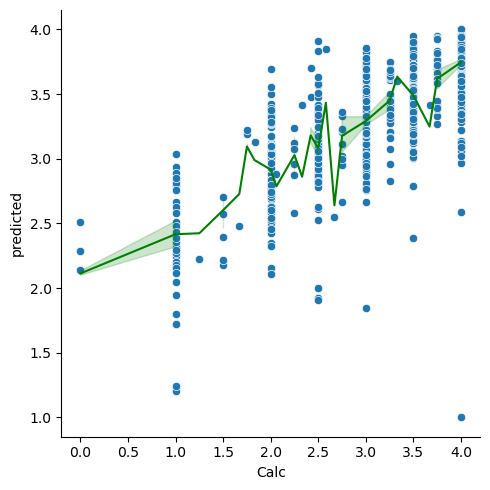

In [88]:
#All students for Calc the predicted grade
sub2["predicted"] = fittedm.predict(sm.add_constant(Xx))

ax = sns.relplot(kind='scatter', x='Calc', y='Cumulative GPA', data=sub2)
ax.map_dataframe(sns.lineplot, 'Calc', 'predicted', color='g')

C:\Users\kmconrad3\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


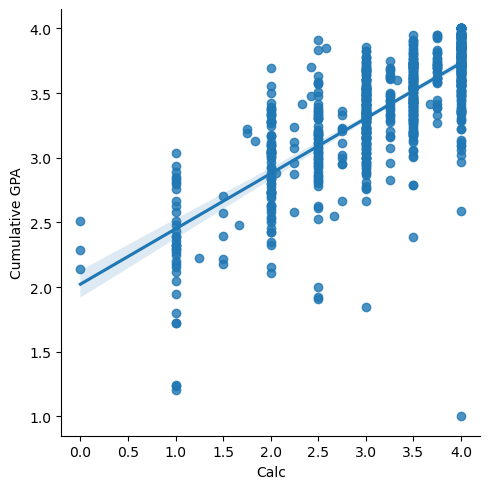

In [89]:
sns.lmplot(x="Calc", y="Cumulative GPA", data=sub2);

C:\Users\kmconrad3\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


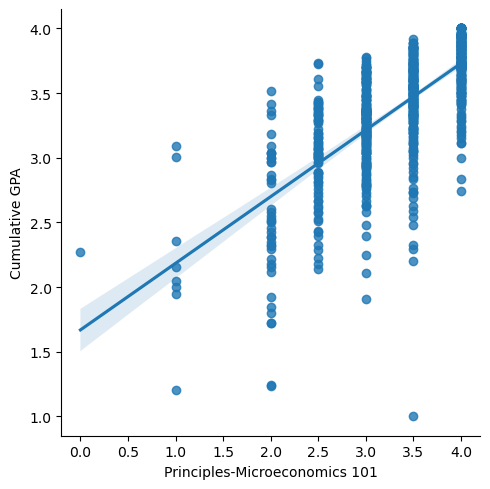

In [90]:
sns.lmplot(x="Principles-Microeconomics 101", y="Cumulative GPA", data=sub2);

C:\Users\kmconrad3\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


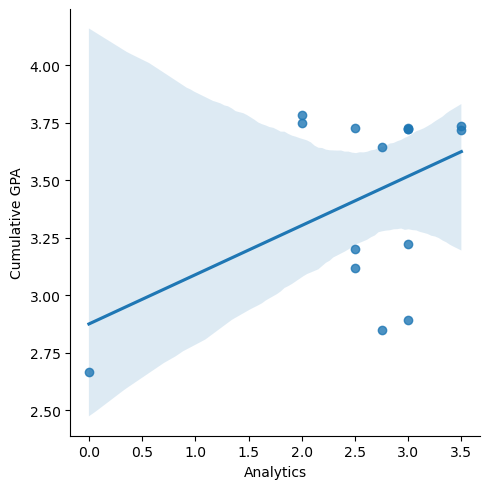

In [91]:
sns.lmplot(x="Analytics", y="Cumulative GPA", data=sub2);

C:\Users\kmconrad3\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


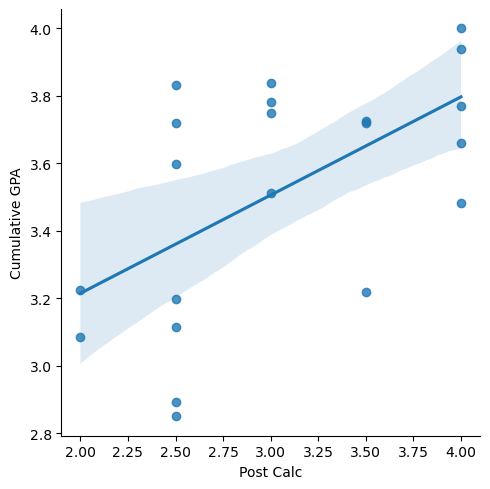

In [92]:
sns.lmplot(x="Post Calc", y="Cumulative GPA", data=sub2);

C:\Users\kmconrad3\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


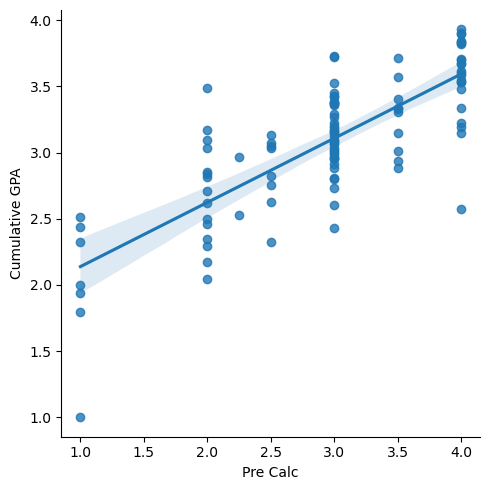

In [93]:
sns.lmplot(x="Pre Calc", y="Cumulative GPA", data=sub2);

### Using NaN vals

In [94]:
#GRADIENT BOOSTING- series of bootstrapping
y = for_pred["Cumulative GPA"]
X = for_pred[["Academic Codes", 'Introduction to Finance 300', "Principles-Macroeconomics 102", "Principles-Microeconomics 101", "Calc", "Pre Calc", "Post Calc", "Analytics", "Adv Econ", \
             "Calc Count", "Pre Calc Count", "Post Calc Count", "Analytics Count", "Adv Econ Count"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
hgb = HistGradientBoostingRegressor() #Catagorical param lets you say which columns are catagorical

#est = hgb.fit(X_train, y_train)
#est.score(X_train, y_train) #R2 of predict
#est.get_params()
#est.score( X_test, est.predict(X_test))


parameters= {'max_leaf_nodes': [31, 24, 20, 35],
              'l2_regularization':[0, 5, 10],
              'learning_rate': [0.001, 0.01, 0.1, 1.0],
              'max_bins':[255, 226, 200],
              'max_iter':[230, 250, 280]}

grid_search = GridSearchCV(estimator = hgb, param_grid = parameters, n_jobs=-1, cv=3)
grid_search.fit(X_train, y_train)
y_pred_grid = grid_search.predict(X_test)
grid_search.best_params_

{'l2_regularization': 10,
 'learning_rate': 0.1,
 'max_bins': 255,
 'max_iter': 250,
 'max_leaf_nodes': 20}

In [95]:
grid_search.best_score_

0.6937065644719947

In [96]:
#linear reg with CATEGORICAL VARIABLES
col_cat = ['Introduction to Finance 300', 'Principles-Macroeconomics 102', 'Principles-Microeconomics 101', 'Calc', 'Pre Calc', 'Post Calc', 'Analytics', 'Adv Econ']
sub_cat=for_pred.copy(deep=True)

for col in col_cat:
    sub_cat[col] = sub_cat[col].apply(lambda x: "C Range" if (x<2.5 and x>=2) \
                                       else ("A Range" if x>=3.6 \
                                           else ("AB Range" if (x<3.6 and x>=3.3) \
                                                else ("B Range" if (x<3.3 and x>=3) \
                                                     else ("BC Range" if (x<3 and x>=2.5) \
                                                          else ("D/F Range" if x<1.99
                                                               else "_None" ) ) ))))
    sub_cat[col] = sub_cat[col].astype("category")
    
for col in sub_cat.columns:
    sub_cat.rename(columns={col : col.replace(" ", "").replace("-", "")}, inplace = True)
    
    
#this doesn't work with sklearn package
y = sub_cat["CumulativeGPA"]
X = sub_cat[["AcademicCodes", "PrinciplesMacroeconomics102", "PrinciplesMicroeconomics101", "IntroductiontoFinance300", "Calc", "PreCalc", "PostCalc", "Analytics", "AdvEcon", \
             "CalcCount", "PreCalcCount", "PostCalcCount", "AnalyticsCount", "AdvEconCount"]]

#model = linear_model.LinearRegression()
#model.fit(X, y)
#model.score(X, y)

In [97]:
model = ols("""CumulativeGPA ~ C(AcademicCodes) + C(IntroductiontoFinance300, Treatment(reference='B Range')) + C(PrinciplesMacroeconomics102, Treatment(reference='B Range')) + 
        C(PrinciplesMicroeconomics101, Treatment(reference='B Range')) + C(Calc, Treatment(reference='B Range')) + CalcCount + C(PreCalc, Treatment(reference='B Range')) + PreCalcCount +
        C(PostCalc, Treatment(reference='B Range')) + PostCalcCount + C(Analytics, Treatment(reference='B Range')) + AnalyticsCount + C(AdvEcon, Treatment(reference='B Range')) + AdvEconCount""", data=sub_cat)
fitted_model = model.fit() 

print(fitted_model.summary()) # Freshman with Okay grade as the baseline state
#fitted_model.predict(X)

                            OLS Regression Results                            
Dep. Variable:          CumulativeGPA   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     190.6
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        11:00:15   Log-Likelihood:                -920.61
No. Observations:                5984   AIC:                             1955.
Df Residuals:                    5927   BIC:                             2337.
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

In [98]:
model = ols("""CumulativeGPA ~ C(AcademicCodes) + C(IntroductiontoFinance300, Treatment(reference='A Range')) + C(PrinciplesMacroeconomics102, Treatment(reference='A Range')) + 
        C(PrinciplesMicroeconomics101, Treatment(reference='A Range')) + C(Calc, Treatment(reference='A Range')) + CalcCount + C(PreCalc, Treatment(reference='A Range')) + PreCalcCount +
        C(PostCalc, Treatment(reference='A Range')) + PostCalcCount + C(Analytics, Treatment(reference='A Range')) + AnalyticsCount + C(AdvEcon, Treatment(reference='A Range')) + AdvEconCount""", data=sub_cat)
fitted_model = model.fit() 

print(fitted_model.summary()) # Freshman with Okay grade as the baseline state
#fitted_model.predict(X)

                            OLS Regression Results                            
Dep. Variable:          CumulativeGPA   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     190.6
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        11:00:15   Log-Likelihood:                -920.61
No. Observations:                5984   AIC:                             1955.
Df Residuals:                    5927   BIC:                             2337.
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

In [99]:
model = ols("""CumulativeGPA ~ C(AcademicCodes) + C(IntroductiontoFinance300, Treatment(reference='_None')) + C(PrinciplesMacroeconomics102, Treatment(reference='_None')) + 
        C(PrinciplesMicroeconomics101, Treatment(reference='_None')) + C(Calc, Treatment(reference='_None')) + CalcCount + C(PreCalc, Treatment(reference='_None')) + PreCalcCount +
        C(PostCalc, Treatment(reference='_None')) + PostCalcCount + C(Analytics, Treatment(reference='_None')) + AnalyticsCount + C(AdvEcon, Treatment(reference='_None')) + AdvEconCount""", data=sub_cat)
fitted_model = model.fit() 

print(fitted_model.summary()) # Freshman with Okay grade as the baseline state
#fitted_model.predict(X)

                            OLS Regression Results                            
Dep. Variable:          CumulativeGPA   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     190.6
Date:                Fri, 16 Feb 2024   Prob (F-statistic):               0.00
Time:                        11:00:15   Log-Likelihood:                -920.61
No. Observations:                5984   AIC:                             1955.
Df Residuals:                    5927   BIC:                             2337.
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                                                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [100]:
sub_cat.columns

Index(['CampusID', 'AcademicLevel', 'CumulativeGPA',
       'IntroductiontoFinance300', 'PrinciplesMacroeconomics102',
       'PrinciplesMicroeconomics101', 'Calc', 'CalcCount', 'PreCalc',
       'PreCalcCount', 'PostCalc', 'PostCalcCount', 'Analytics',
       'AnalyticsCount', 'AdvEcon', 'AdvEconCount', 'AcademicCodes'],
      dtype='object', name='Class')

In [101]:
sub2[['Cumulative GPA', 'Calc Count', 'Pre Calc Count', 'Post Calc Count', 'Analytics Count', 'Adv Econ Count', 'Academic Codes']].corr() # only of people who've taken calc & 102/101

Class,Cumulative GPA,Calc Count,Pre Calc Count,Post Calc Count,Analytics Count,Adv Econ Count,Academic Codes
Class,,,,,,,
Cumulative GPA,1.000000,0.036874,-0.256635,0.054641,0.045604,0.038867,0.196706
Calc Count,0.036874,1.000000,-0.142676,0.070189,0.012843,0.027869,0.105792
Pre Calc Count,-0.256635,-0.142676,1.000000,-0.052648,-0.037595,0.005765,-0.137925
Post Calc Count,0.054641,0.070189,-0.052648,1.000000,0.398905,0.188297,0.236170
Analytics Count,0.045604,0.012843,-0.037595,0.398905,1.000000,0.522311,0.244470
Adv Econ Count,0.038867,0.027869,0.005765,0.188297,0.522311,1.000000,0.214311
Academic Codes,0.196706,0.105792,-0.137925,0.236170,0.244470,0.214311,1.000000


In [102]:
for_pred[['Cumulative GPA', 'Calc Count', 'Pre Calc Count', 'Post Calc Count', 'Analytics Count', 'Adv Econ Count', 'Academic Codes']].corr() #SAME AS BELOW

Class,Cumulative GPA,Calc Count,Pre Calc Count,Post Calc Count,Analytics Count,Adv Econ Count,Academic Codes
Class,,,,,,,
Cumulative GPA,1.000000,-0.122877,-0.288018,0.061694,0.115818,0.089398,0.169838
Calc Count,-0.122877,1.000000,-0.066840,-0.013255,-0.121138,-0.170412,-0.092579
Pre Calc Count,-0.288018,-0.066840,1.000000,-0.049147,-0.074988,-0.088852,-0.194710
Post Calc Count,0.061694,-0.013255,-0.049147,1.000000,0.126040,0.082888,0.215272
Analytics Count,0.115818,-0.121138,-0.074988,0.126040,1.000000,0.525957,0.326639
Adv Econ Count,0.089398,-0.170412,-0.088852,0.082888,0.525957,1.000000,0.449015
Academic Codes,0.169838,-0.092579,-0.194710,0.215272,0.326639,0.449015,1.000000


In [103]:
sub_cat.corr() #excludes the categorical columns

ValueError: could not convert string to float: 'Freshman'

In [ ]:
#Subsets of different grade level and effect classes have on gpa

## Graphs

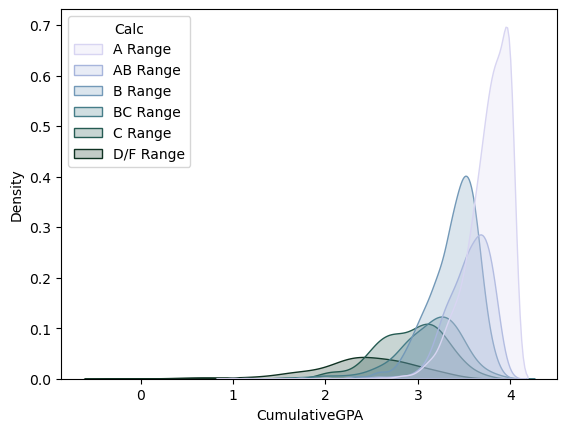

In [109]:
#sns.pairplot(sub_cat, x_vars=['CumulativeGPA','CalcCount'],y_vars=['CumulativeGPA', "CalcCount"], hue='Calc') # kde is 
hueo = ['A Range', 'AB Range', 'B Range', "BC Range", "C Range", "D/F Range"]   
ax = sns.kdeplot(sub_cat[sub_cat["Calc"] != "_None"], x ='CumulativeGPA', hue='Calc', palette=sns.cubehelix_palette(start=2), hue_order=hueo, fill=True) #can also remove a certain category by excluding it in hue_order
sns.move_legend(ax, "upper left")
fig = ax.get_figure()
fig.savefig("output.png")

In [ ]:
ax = sns.kdeplot(sub_cat[sub_cat["PreCalc"] != "_None"], x ='CumulativeGPA', hue='PreCalc', palette=sns.cubehelix_palette(start=2), fill=True)
sns.move_legend(ax, "upper left")
fig = ax.get_figure()
fig.savefig("output2.png")

In [ ]:
ax = sns.kdeplot(sub_cat[sub_cat["AdvEcon"] != "_None"], x ='CumulativeGPA', hue='AdvEcon', palette=sns.cubehelix_palette(start=2), fill=True)
sns.move_legend(ax, "upper left")
fig = ax.get_figure()
fig.savefig("output3.png")

In [ ]:
ax = sns.kdeplot(sub_cat[sub_cat["Analytics"] != "_None"], x ='CumulativeGPA', hue='Analytics', palette=sns.cubehelix_palette(start=2), fill=True)
sns.move_legend(ax, "upper left")
fig = ax.get_figure()
fig.savefig("output4.png")

In [ ]:
ax = sns.kdeplot(sub_cat[sub_cat["PostCalc"] != "_None"], x ='CumulativeGPA', hue='PostCalc', palette=sns.cubehelix_palette(start=2), fill=True)
sns.move_legend(ax, "upper left")
fig = ax.get_figure()
fig.savefig("output5.png")

In [ ]:
g = sns.PairGrid(data=for_pred, x_vars=["Analytics", "Post Calc", "Calc", "Pre Calc"], y_vars=["Cumulative GPA"], hue="Academic Level", height=4)
g.map(sns.regplot) #sns.scatterplot
g.add_legend()
g.savefig("pic")

In [ ]:
gr = sns.PairGrid(data=for_pred, x_vars=['Introduction to Finance 300', 'Principles-Macroeconomics 102', 'Principles-Microeconomics 101', "Adv Econ"], y_vars=["Cumulative GPA"], hue="Academic Level", height=4)
gr.map(sns.regplot) #sns.scatterplot
gr.add_legend()
gr.savefig("pic2")

In [ ]:
#just FRESHMAN who've taken the following classes
gr = sns.PairGrid(data=sub_cat[sub_cat["AcademicLevel"]=="Freshman"], x_vars=['Analytics', 'PrinciplesMacroeconomics102', \
                                                                                   'PrinciplesMicroeconomics101', "Calc", "PreCalc"], y_vars=["CumulativeGPA"])
for ax in gr.axes.flatten():
    ax.tick_params(rotation = 90)
    
gr.map(sns.boxplot, order=hueo)

In [ ]:
gr = sns.PairGrid(data=sub_cat[sub_cat["AcademicLevel"]=="Senior"], x_vars=['Analytics', 'PrinciplesMacroeconomics102', \
                                                                                   'PrinciplesMicroeconomics101', "Calc", "PreCalc"], y_vars=["CumulativeGPA"])
for ax in gr.axes.flatten():
    ax.tick_params(rotation = 90)
    
gr.map(sns.boxplot, order=hueo)

In [ ]:
gr = sns.PairGrid(data=sub_cat[sub_cat["AcademicLevel"]=="Sophomore"], x_vars=['Analytics', 'IntroductiontoFinance300', \
                                                                                   'AdvEcon', "Calc", "PostCalc"], y_vars=["CumulativeGPA"])
for ax in gr.axes.flatten():
    ax.tick_params(rotation = 90)
    
gr.map(sns.boxplot, order=hueo)

In [ ]:
gr = sns.PairGrid(data=sub_cat[sub_cat["AcademicLevel"]=="Junior"], x_vars=['Analytics', 'IntroductiontoFinance300', \
                                                                                   'AdvEcon', "Calc", "PostCalc"], y_vars=["CumulativeGPA"])
for ax in gr.axes.flatten():
    ax.tick_params(rotation = 90)
    
gr.map(sns.boxplot, order=hueo)

In [ ]:
gr = sns.PairGrid(data=sub_cat[sub_cat["AcademicLevel"]=="Senior"], x_vars=['Analytics', 'IntroductiontoFinance300', \
                                                                                   'AdvEcon', "Calc", "PostCalc"], y_vars=["CumulativeGPA"])
for ax in gr.axes.flatten():
    ax.tick_params(rotation = 90)
    
gr.map(sns.boxplot, order=hueo)

In [ ]:
sns.boxplot(data=for_pred, x="Academic Level", y="Cumulative GPA", showcaps=True, flierprops={"marker": "x"})

### Panel data

In [ ]:
##Pooled OLS 
from linearmodels import PooledOLS
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

model = PanelOLS.from_formula('CumulativeGPA ~ 1 + CalcCount + PreCalcCount + EntityEffects', sub_cat)

#model = PanelOLS.from_formula("""CumulativeGPA ~ C(AcademicCodes) + C(IntroductiontoFinance300, Treatment(reference='_None')) + C(PrinciplesMacroeconomics102, Treatment(reference='_None')) +
#        C(PrinciplesMicroeconomics101, Treatment(reference='_None')) + C(Calc, Treatment(reference='_None')) + CalcCount + C(PreCalc, Treatment(reference='_None')) + PreCalcCount +
#        C(PostCalc, Treatment(reference='_None')) + PostCalcCount + C(Analytics, Treatment(reference='_None')) + AnalyticsCount + C(AdvEcon, Treatment(reference='_None')) + AdvEconCount + EntityEffects """, sub_cat)



results = model.fit(cov_type='clustered', cluster_entity=True)
print(results)

In [ ]:
exog = sm.tools.tools.add_constant(for_pred['Cumulative GPA'])
endog = for_pred[['Pre Calc', 'Calc']]
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)
# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

In [ ]:
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')
ax.set_title('Homoskedasticity Test')
plt.show()